# Part 6: Visualization & Interpretation

## Objectives
This notebook provides comprehensive visualization and interpretation of our portfolio analysis, focusing on:

1. **Portfolio Performance Visualization**: Compare hedged vs. unhedged portfolio values over time
2. **Drawdown Analysis**: Visualize and analyze portfolio drawdown characteristics
3. **Return Distribution Analysis**: KDE and histogram analysis of return distributions
4. **Impact Analysis**: Quantify and visualize the impact of hedging on volatility and drawdown
5. **Signal-Based Analysis**: Examine the impact of signal-based weighting on portfolio dynamics
6. **Key Takeaways**: Comprehensive summary and interpretation of findings

## Section 1: Setup and Data Loading

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Set enhanced plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

print("Libraries imported and plotting style configured")

Libraries imported and plotting style configured


In [52]:
# Load all relevant data files
print("Loading data from previous parts...\n")

# Part 5: Portfolio timeseries with hedging and transaction costs
portfolio_data = pd.read_csv(
    '../Part 5: Backtesting & Performance Evaluation/'
    'portfolio_timeseries_with_transaction_costs.csv'
)
portfolio_data['Date'] = pd.to_datetime(portfolio_data['Date'])
portfolio_data.set_index('Date', inplace=True)

# display head of portfolio data
display(portfolio_data.head())

# Performance metrics
metrics_data = pd.read_csv(
    '../Part 5: Backtesting & Performance Evaluation/'
    'performance_metrics_comparison.csv',
    index_col=0
)
# display head of metrics data
display(metrics_data.head())

# Signal-based portfolio data (from Part 2.5)
signal_performance = pd.read_csv(
    '../Part 2.5: Technical Indicators & Signal Design/'
    'portfolio_performance_comparison.csv'
)

# display head of signal performance data
display(signal_performance.head())

print("\nData loading completed successfully!")

Loading data from previous parts...



,Unhedged_Portfolio_Value,Hedged_Portfolio_Value,Daily_Hedge_Ratio,Unhedged_Daily_TC,Unhedged_Cumulative_TC,Unhedged_Portfolio_Value_Net,Unhedged_Portfolio_Return_Net,Hedged_Equity_Daily_TC,Hedged_SPY_Daily_TC,Hedged_Daily_TC,Hedged_Cumulative_TC,Hedged_Portfolio_Value_Net,Hedged_Portfolio_Return_Net
Date,,,,,,,,,,,,,
2020-08-07,100000.000000,100000.000000,294.512154,50.0,50.0,99950.000000,NaN,50.0,30.000000,80.000000,80.000000,99920.000000,NaN
2020-08-10,100613.150620,100272.853863,295.434925,0.0,50.0,100563.150620,0.006135,0.0,30.081856,30.081856,110.081856,100162.772007,0.002430
2020-08-11,100361.130310,100781.101451,297.147771,0.0,50.0,100311.130310,-0.002506,0.0,30.234330,30.234330,140.316187,100640.785264,0.004772
2020-08-12,101124.066530,100258.059637,295.289627,0.0,50.0,101074.066530,0.007606,0.0,30.077418,30.077418,170.393604,100087.666032,-0.005496
2020-08-13,100898.681586,100200.890993,295.165076,0.0,50.0,100848.681586,-0.002230,0.0,30.060267,30.060267,200.453872,100000.437121,-0.000872


,Unhedged,Unhedged (Net),Hedged,Hedged (Net)
Annualized Return,0.139903,0.139958,0.003242,-0.088181
Annualized Volatility,0.171308,0.171372,0.045191,0.057694
Sharpe Ratio,0.816673,0.816688,0.071735,-1.528419
Sortino Ratio,1.112339,1.112365,0.115306,-2.321452
Calmar Ratio,0.590969,0.590999,0.037505,-0.230880


,Date,Signal_Weighted_Value,Equal_Weight_Value,Signal_Weighted_Returns,Equal_Weight_Returns,Signal_Weighted_Cumulative_Return,Equal_Weight_Cumulative_Return
0,2020-08-07,100000.000000,NaN,0.000000,NaN,0.000000,NaN
1,2020-08-10,100639.510966,100639.510966,0.006395,0.006395,0.639511,0.639511
2,2020-08-11,100404.735775,100404.735775,-0.002333,-0.002333,0.404736,0.404736
3,2020-08-12,101184.302877,101184.302877,0.007764,0.007764,1.184303,1.184303
4,2020-08-13,100976.137477,100976.137477,-0.002057,-0.002057,0.976137,0.976137



Data loading completed successfully!


## Section 2: Portfolio Values Visualization (Hedged vs. Unhedged)

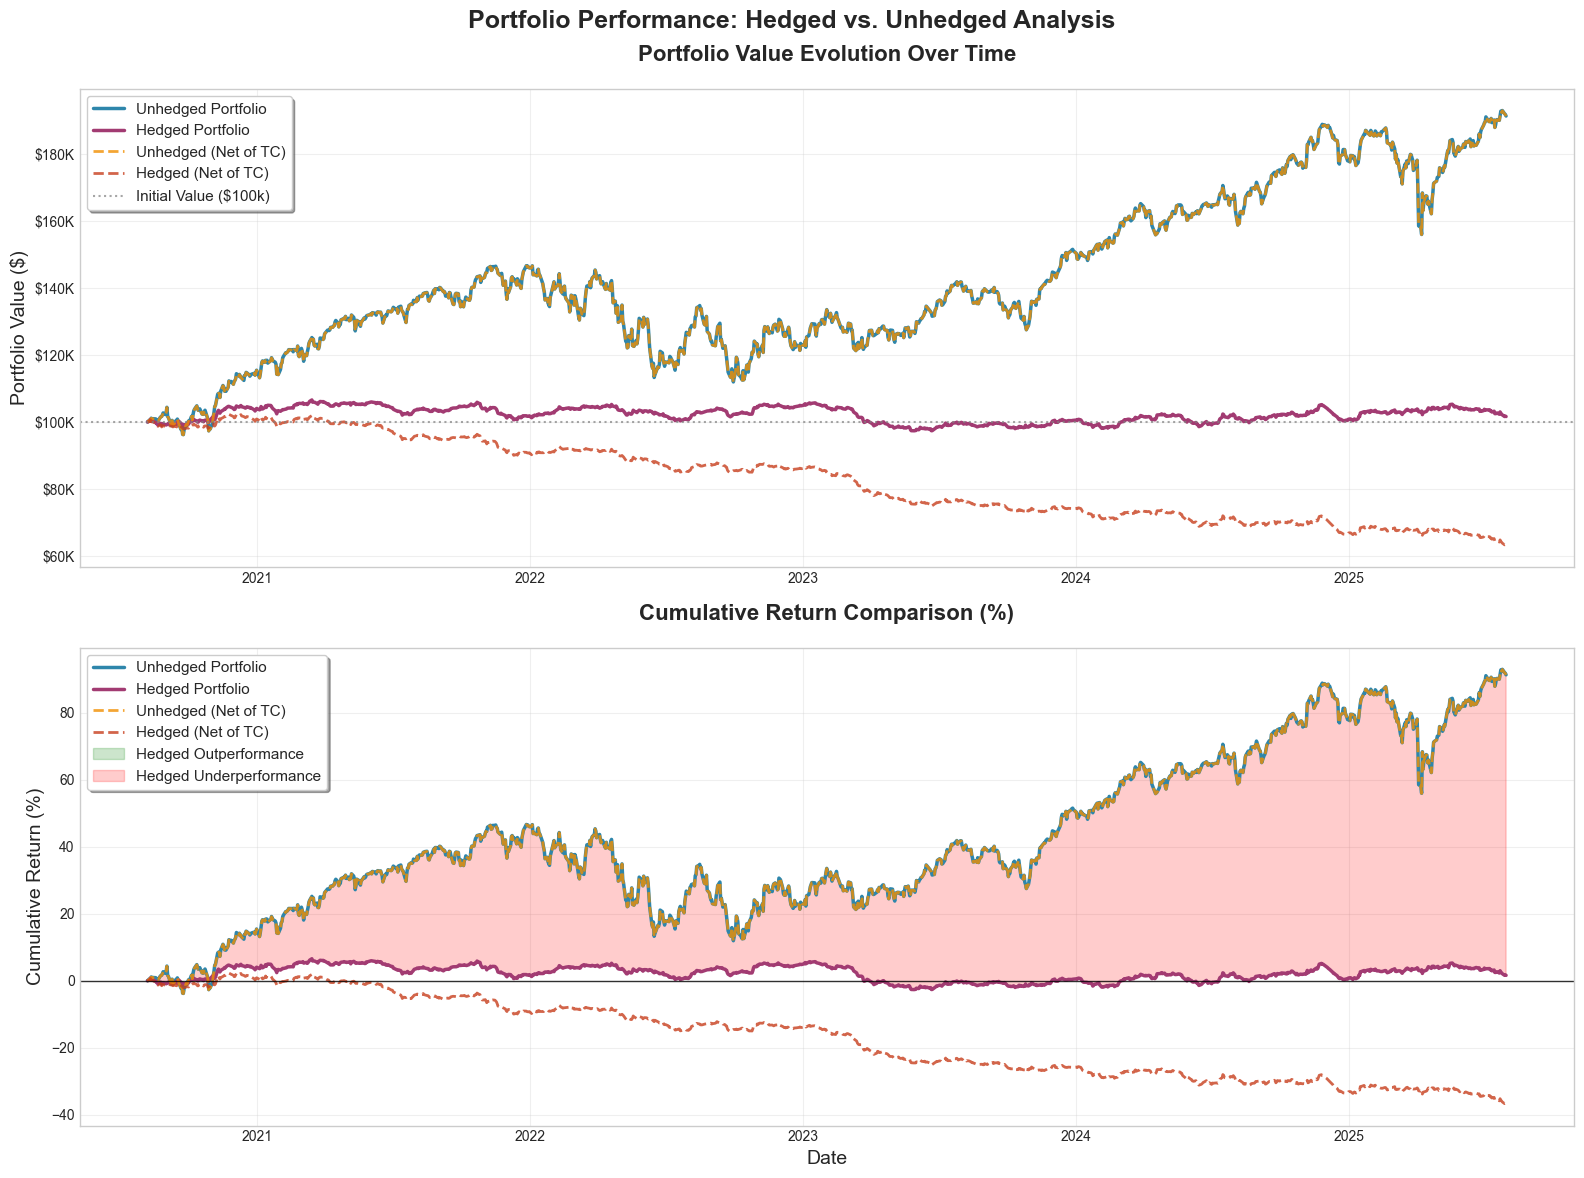

In [53]:
# Visualize portfolio values: Hedged vs. Unhedged
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle(
    'Portfolio Performance: Hedged vs. Unhedged Analysis',
    fontsize=18, fontweight='bold', y=0.98
)

# --- Top panel: Portfolio values over time ---
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

ax1.plot(
    portfolio_data.index, portfolio_data['Unhedged_Portfolio_Value'],
    label='Unhedged Portfolio', linewidth=2.5, color=colors[0]
)
ax1.plot(
    portfolio_data.index, portfolio_data['Hedged_Portfolio_Value'],
    label='Hedged Portfolio', linewidth=2.5, color=colors[1]
)
ax1.plot(
    portfolio_data.index, portfolio_data['Unhedged_Portfolio_Value_Net'],
    label='Unhedged (Net of TC)', linewidth=2, 
    linestyle='--', color=colors[2], alpha=0.8
)
ax1.plot(
    portfolio_data.index, portfolio_data['Hedged_Portfolio_Value_Net'],
    label='Hedged (Net of TC)', linewidth=2, 
    linestyle='--', color=colors[3], alpha=0.8
)

# Add initial value reference line
ax1.axhline(
    y=100000, color='gray', linestyle=':', 
    alpha=0.7, label='Initial Value ($100k)'
)

# Formatting
ax1.set_title('Portfolio Value Evolution Over Time', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Portfolio Value ($)', fontsize=14)
ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K')
)

# --- Bottom panel: Relative performance comparison ---
base_unhedged = portfolio_data['Unhedged_Portfolio_Value'].iloc[0]
base_hedged = portfolio_data['Hedged_Portfolio_Value'].iloc[0]

unhedged_perf = (
    (portfolio_data['Unhedged_Portfolio_Value'] / base_unhedged - 1) * 100
)
hedged_perf = (
    (portfolio_data['Hedged_Portfolio_Value'] / base_hedged - 1) * 100
)
unhedged_net_perf = (
    (portfolio_data['Unhedged_Portfolio_Value_Net'] / base_unhedged - 1) * 100
)
hedged_net_perf = (
    (portfolio_data['Hedged_Portfolio_Value_Net'] / base_hedged - 1) * 100
)

ax2.plot(
    portfolio_data.index, unhedged_perf,
    label='Unhedged Portfolio', linewidth=2.5, color=colors[0]
)
ax2.plot(
    portfolio_data.index, hedged_perf,
    label='Hedged Portfolio', linewidth=2.5, color=colors[1]
)
ax2.plot(
    portfolio_data.index, unhedged_net_perf,
    label='Unhedged (Net of TC)', linewidth=2, 
    linestyle='--', color=colors[2], alpha=0.8
)
ax2.plot(
    portfolio_data.index, hedged_net_perf,
    label='Hedged (Net of TC)', linewidth=2, 
    linestyle='--', color=colors[3], alpha=0.8
)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
ax2.fill_between(
    portfolio_data.index, unhedged_perf, hedged_perf,
    alpha=0.2, color='green', where=(hedged_perf >= unhedged_perf),
    label='Hedged Outperformance', interpolate=True
)
ax2.fill_between(
    portfolio_data.index, unhedged_perf, hedged_perf,
    alpha=0.2, color='red', where=(hedged_perf < unhedged_perf),
    label='Hedged Underperformance', interpolate=True
)

ax2.set_title('Cumulative Return Comparison (%)', 
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Cumulative Return (%)', fontsize=14)
ax2.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('portfolio_values_hedged_vs_unhedged.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Drawdown Analysis

In [54]:
# Calculate drawdowns for detailed analysis
def calculate_drawdown_stats(returns, name):
    """Calculate comprehensive drawdown statistics"""
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    
    # Key statistics
    max_dd = drawdown.min()
    avg_dd = (drawdown[drawdown < 0].mean() 
              if len(drawdown[drawdown < 0]) > 0 else 0)
    dd_duration = (drawdown < -0.05).sum()  # Days with >5% drawdown
    
    return {
        'name': name,
        'drawdown_series': drawdown,
        'max_drawdown': max_dd,
        'avg_drawdown': avg_dd,
        'severe_dd_days': dd_duration
    }

# Calculate drawdown statistics
unhedged_net_dd = calculate_drawdown_stats(
    portfolio_data['Unhedged_Portfolio_Return_Net'].dropna(), 'Unhedged (Net)'
)
hedged_net_dd = calculate_drawdown_stats(
    portfolio_data['Hedged_Portfolio_Return_Net'].dropna(), 'Hedged (Net)'
)

print("Drawdown Statistics Comparison:")
print("=" * 50)
for dd_data in [unhedged_net_dd, hedged_net_dd]:
    print(f"{dd_data['name']:15}: Max DD = {dd_data['max_drawdown']*100:6.2f}%, "
          f"Avg DD = {dd_data['avg_drawdown']*100:6.2f}%, "
          f"Severe DD Days = {dd_data['severe_dd_days']:3d}")

Drawdown Statistics Comparison:
Unhedged (Net) : Max DD = -23.68%, Avg DD =  -6.26%, Severe DD Days = 483
Hedged (Net)   : Max DD = -38.19%, Avg DD = -18.98%, Severe DD Days = 1024


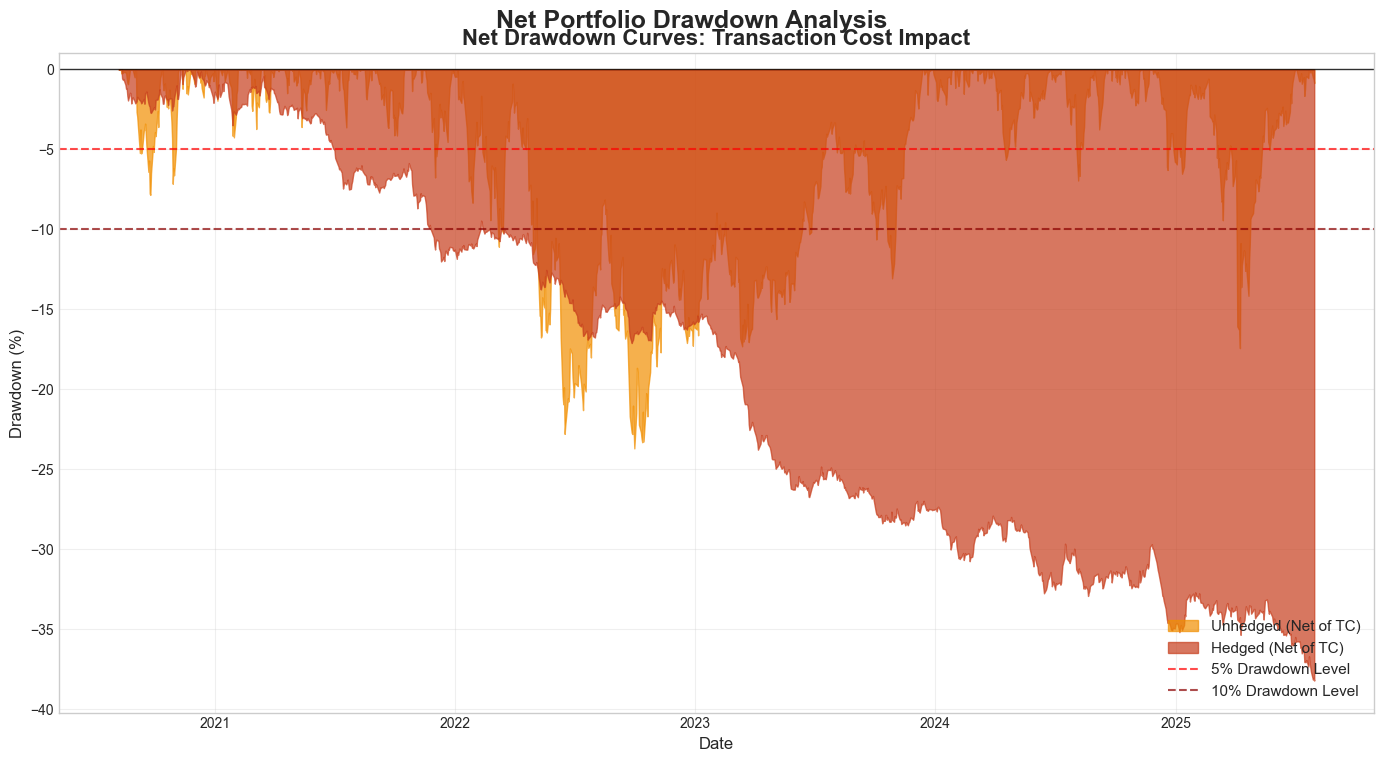


Net Drawdown Statistics:
Unhedged (Net of TC)  : Max DD = -23.68%
Hedged (Net of TC)    : Max DD = -38.19%
Difference            : -14.51%


In [55]:
# Create net drawdown visualization
def calculate_drawdown_from_values(values):
    """Calculate drawdown from portfolio values directly"""
    rolling_max = values.expanding().max()
    drawdown = (values - rolling_max) / rolling_max
    return drawdown

# Calculate net drawdowns directly from net portfolio values
unhedged_net_drawdown = calculate_drawdown_from_values(
    portfolio_data['Unhedged_Portfolio_Value_Net']
)
hedged_net_drawdown = calculate_drawdown_from_values(
    portfolio_data['Hedged_Portfolio_Value_Net']
)

# Create single panel visualization for net drawdowns only
fig, ax = plt.subplots(figsize=(14, 8))
fig.suptitle('Net Portfolio Drawdown Analysis', 
             fontsize=18, fontweight='bold', y=0.95)

# Plot net drawdowns as filled areas
ax.fill_between(
    portfolio_data.index, unhedged_net_drawdown * 100, 0,
    alpha=0.7, color=colors[2], label='Unhedged (Net of TC)'
)
ax.fill_between(
    portfolio_data.index, hedged_net_drawdown * 100, 0,
    alpha=0.7, color=colors[3], label='Hedged (Net of TC)'
)

# Add reference lines
ax.axhline(y=-5, color='red', linestyle='--', 
           alpha=0.7, label='5% Drawdown Level')
ax.axhline(y=-10, color='darkred', linestyle='--', 
           alpha=0.7, label='10% Drawdown Level')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)

# Formatting
ax.set_title('Net Drawdown Curves: Transaction Cost Impact', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim(
    min(unhedged_net_drawdown.min(), hedged_net_drawdown.min()) * 100 - 2, 1
)

plt.tight_layout()
plt.savefig('net_drawdown_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Display net drawdown statistics
print("\nNet Drawdown Statistics:")
print("=" * 50)
print(f"Unhedged (Net of TC)  : Max DD = {unhedged_net_drawdown.min()*100:6.2f}%")
print(f"Hedged (Net of TC)    : Max DD = {hedged_net_drawdown.min()*100:6.2f}%")
print(f"Difference            : "
      f"{(hedged_net_drawdown.min() - unhedged_net_drawdown.min())*100:6.2f}%")

## Section 4: Return Distribution Analysis (Histograms/KDE)

Calculating return distributions...


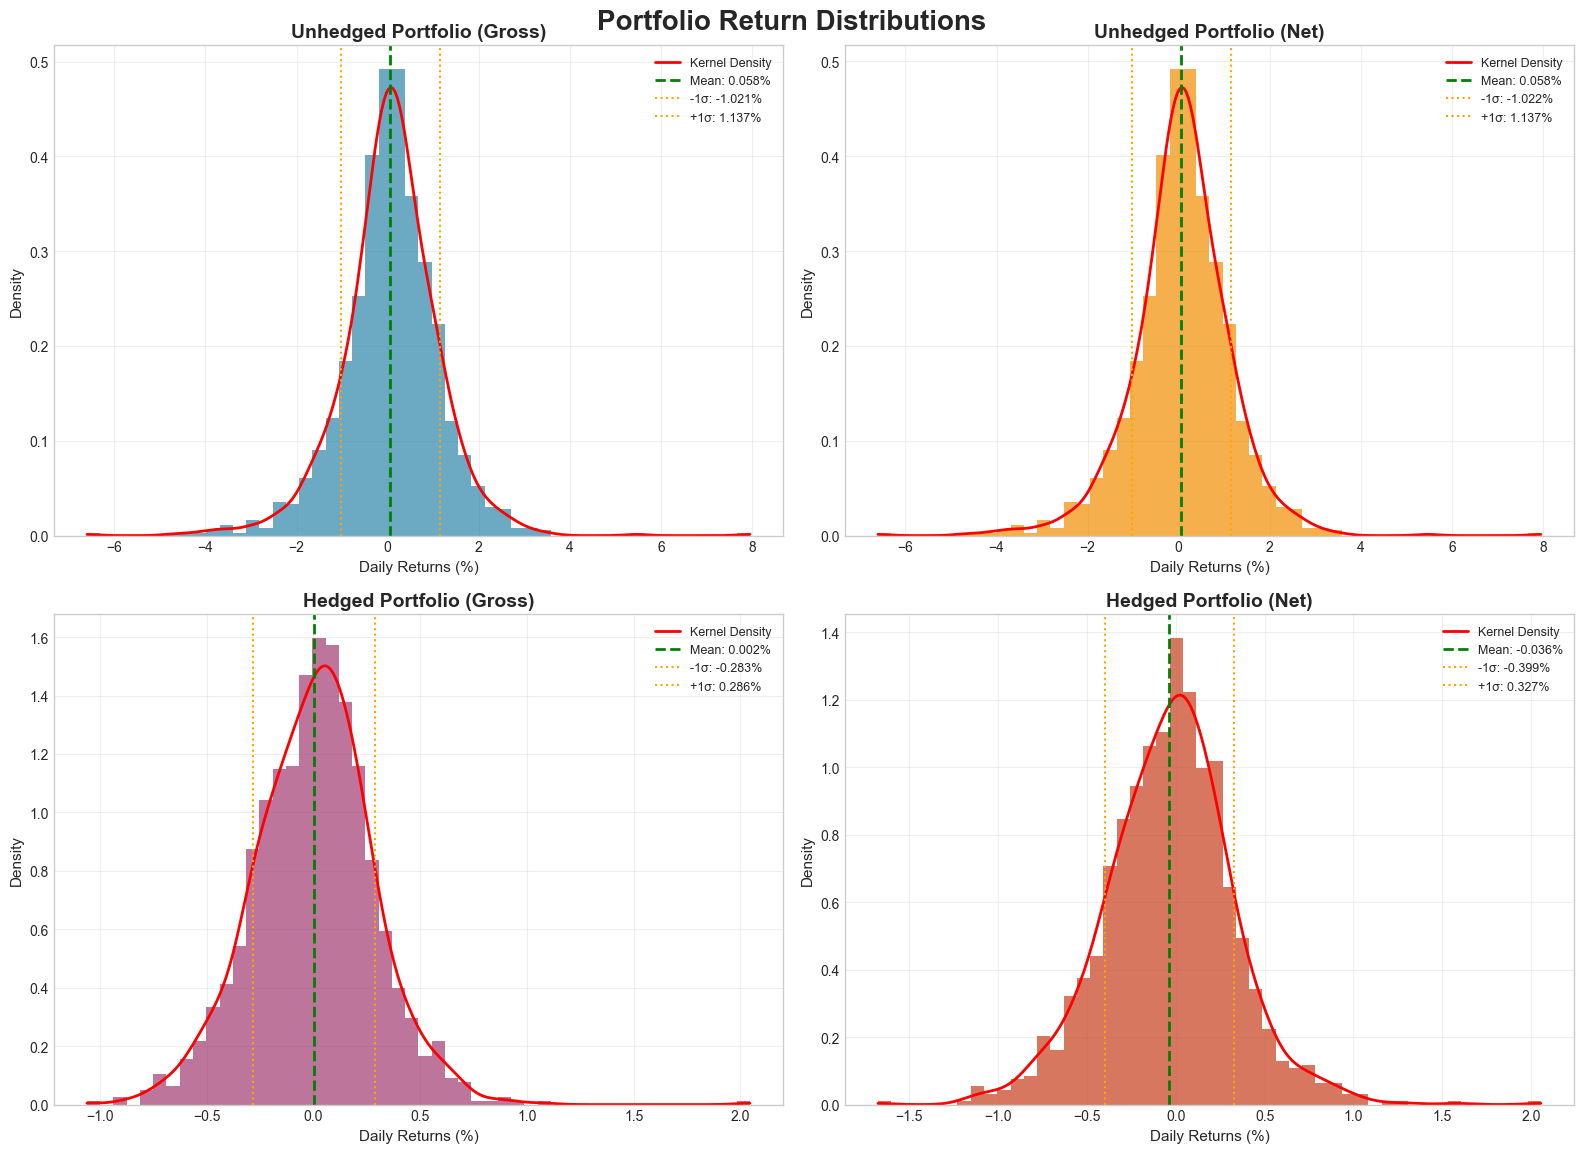


Return Distribution Summary:
Unhedged Portfolio (Gross): Mean= 0.058%, Std= 1.079%, Skew=-0.139, Kurt= 4.882
Unhedged Portfolio (Net) : Mean= 0.058%, Std= 1.080%, Skew=-0.139, Kurt= 4.881
Hedged Portfolio (Gross) : Mean= 0.002%, Std= 0.285%, Skew= 0.236, Kurt= 2.343
Hedged Portfolio (Net)   : Mean=-0.036%, Std= 0.363%, Skew= 0.105, Kurt= 1.720


In [56]:
# Return Distribution Analysis
print("Calculating return distributions...")

# Calculate returns for all portfolio variants
unhedged_returns = portfolio_data['Unhedged_Portfolio_Value'].pct_change().dropna()
unhedged_net_returns = portfolio_data[
    'Unhedged_Portfolio_Value_Net'
].pct_change().dropna()
hedged_returns = portfolio_data['Hedged_Portfolio_Value'].pct_change().dropna()
hedged_net_returns = portfolio_data[
    'Hedged_Portfolio_Value_Net'
].pct_change().dropna()

# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Portfolio Return Distributions', 
             fontsize=20, fontweight='bold', y=0.96)

# Define portfolio configurations
portfolios = [
    (unhedged_returns * 100, 'Unhedged Portfolio (Gross)', colors[0]),
    (unhedged_net_returns * 100, 'Unhedged Portfolio (Net)', colors[2]),
    (hedged_returns * 100, 'Hedged Portfolio (Gross)', colors[1]),
    (hedged_net_returns * 100, 'Hedged Portfolio (Net)', colors[3])
]

# Create subplot positions
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Plot each portfolio
for (returns, title, color), (i, j) in zip(portfolios, positions):
    ax = axes[i, j]
    
    # Create histogram
    n, bins, patches = ax.hist(returns, bins=50, alpha=0.7, 
                              color=color, density=True)
    
    # Add KDE overlay
    x_smooth = np.linspace(returns.min(), returns.max(), 300)
    kde = gaussian_kde(returns)
    kde_values = kde(x_smooth)
    ax.plot(x_smooth, kde_values, color='red', linewidth=2, 
            label='Kernel Density')
    
    # Add statistics
    mean_ret = returns.mean()
    std_ret = returns.std()
    ax.axvline(mean_ret, color='green', linestyle='--', linewidth=2,
               label=f'Mean: {mean_ret:.3f}%')
    ax.axvline(mean_ret - std_ret, color='orange', linestyle=':', 
               linewidth=1.5, label=f'-1σ: {mean_ret - std_ret:.3f}%')
    ax.axvline(mean_ret + std_ret, color='orange', linestyle=':', 
               linewidth=1.5, label=f'+1σ: {mean_ret + std_ret:.3f}%')
    
    # Formatting
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Daily Returns (%)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('return_distributions_kde.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nReturn Distribution Summary:")
print("=" * 70)
for returns, name, _ in portfolios:
    print(f"{name:25}: Mean={returns.mean():6.3f}%, " 
          f"Std={returns.std():6.3f}%, Skew={returns.skew():6.3f}, "
          f"Kurt={returns.kurtosis():6.3f}")
print("=" * 70)

In [57]:
# Transaction Cost and Hedging Impact Analysis
print("Analyzing transaction cost and hedging impact...")

# Prepare data
analysis_data = []

# Extract metrics for each portfolio
for col in portfolio_data.columns:
    if 'Portfolio_Value' in col:
        returns = portfolio_data[col].pct_change().dropna()
        analysis_data.append({
            'Portfolio': col.replace('_Portfolio_Value', '').replace('_', ' '),
            'Total Return (%)': (portfolio_data[col].iloc[-1] / 
                               portfolio_data[col].iloc[0] - 1) * 100,
            'Annualized Return (%)': returns.mean() * 252 * 100,
            'Volatility (%)': returns.std() * np.sqrt(252) * 100,
            'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252))
        })

# Create clean summary DataFrame
impact_analysis_df = pd.DataFrame(analysis_data)

# Calculate differences
tc_impact_unhedged = (impact_analysis_df.iloc[0]['Total Return (%)'] - 
                     impact_analysis_df.iloc[1]['Total Return (%)'])
tc_impact_hedged = (impact_analysis_df.iloc[2]['Total Return (%)'] - 
                   impact_analysis_df.iloc[3]['Total Return (%)'])
hedge_benefit_gross = (impact_analysis_df.iloc[2]['Total Return (%)'] - 
                      impact_analysis_df.iloc[0]['Total Return (%)'])
hedge_benefit_net = (impact_analysis_df.iloc[3]['Total Return (%)'] - 
                    impact_analysis_df.iloc[1]['Total Return (%)'])

# Display results
print("\nTransaction Cost & Hedging Impact Summary:")
print("=" * 60)
print(impact_analysis_df.round(3).to_string(index=False))
print("\nKey Impacts:")
print(f"Transaction Cost Impact - Unhedged: {tc_impact_unhedged:.2f}%")
print(f"Transaction Cost Impact - Hedged  : {tc_impact_hedged:.2f}%")
print(f"Hedging Benefit (Gross)          : {hedge_benefit_gross:.2f}%")
print(f"Hedging Benefit (Net)            : {hedge_benefit_net:.2f}%")

Analyzing transaction cost and hedging impact...

Transaction Cost & Hedging Impact Summary:
   Portfolio  Total Return (%)  Annualized Return (%)  Volatility (%)  Sharpe Ratio
    Unhedged            91.362                 14.565          17.131         0.850
      Hedged             1.617                  0.426           4.519         0.094
Unhedged Net            91.408                 14.571          17.137         0.850
  Hedged Net           -36.716                 -9.063           5.769        -1.571

Key Impacts:
Transaction Cost Impact - Unhedged: 89.75%
Transaction Cost Impact - Hedged  : 128.12%
Hedging Benefit (Gross)          : 0.05%
Hedging Benefit (Net)            : -38.33%


## Section 5: Impact Analysis of Hedging

In [58]:
# Clean and simple impact analysis summary

def calculate_hedging_impact():
    unhedged_vol = portfolio_data['Unhedged_Portfolio_Return_Net'].std() * np.sqrt(252) * 100
    hedged_vol = portfolio_data['Hedged_Portfolio_Return_Net'].std() * np.sqrt(252) * 100
    unhedged_max_dd = unhedged_net_dd['max_drawdown'] * 100
    hedged_max_dd = hedged_net_dd['max_drawdown'] * 100
    unhedged_return = portfolio_data['Unhedged_Portfolio_Return_Net'].mean() * 252 * 100
    hedged_return = portfolio_data['Hedged_Portfolio_Return_Net'].mean() * 252 * 100
    unhedged_sharpe = (unhedged_return - 2) / unhedged_vol
    hedged_sharpe = (hedged_return - 2) / hedged_vol
    unhedged_var = portfolio_data['Unhedged_Portfolio_Return_Net'].quantile(0.05) * 100
    hedged_var = portfolio_data['Hedged_Portfolio_Return_Net'].quantile(0.05) * 100
    return {
        'Volatility (%)': [unhedged_vol, hedged_vol],
        'Max Drawdown (%)': [unhedged_max_dd, hedged_max_dd],
        'Annual Return (%)': [unhedged_return, hedged_return],
        'Sharpe Ratio': [unhedged_sharpe, hedged_sharpe],
        'VaR 95% (%)': [unhedged_var, hedged_var]
    }

impact = calculate_hedging_impact()

import pandas as pd
summary = pd.DataFrame(impact, index=['Unhedged (Net)', 'Hedged (Net)'])
print("\nImpact Analysis Summary (Net of Transaction Costs):\n")
print(summary.round(2).to_string())


Impact Analysis Summary (Net of Transaction Costs):

                Volatility (%)  Max Drawdown (%)  Annual Return (%)  Sharpe Ratio  VaR 95% (%)
Unhedged (Net)           17.14            -23.68              14.57          0.73        -1.70
Hedged (Net)              5.77            -38.19              -9.06         -1.92        -0.63


Creating performance comparison dashboard...


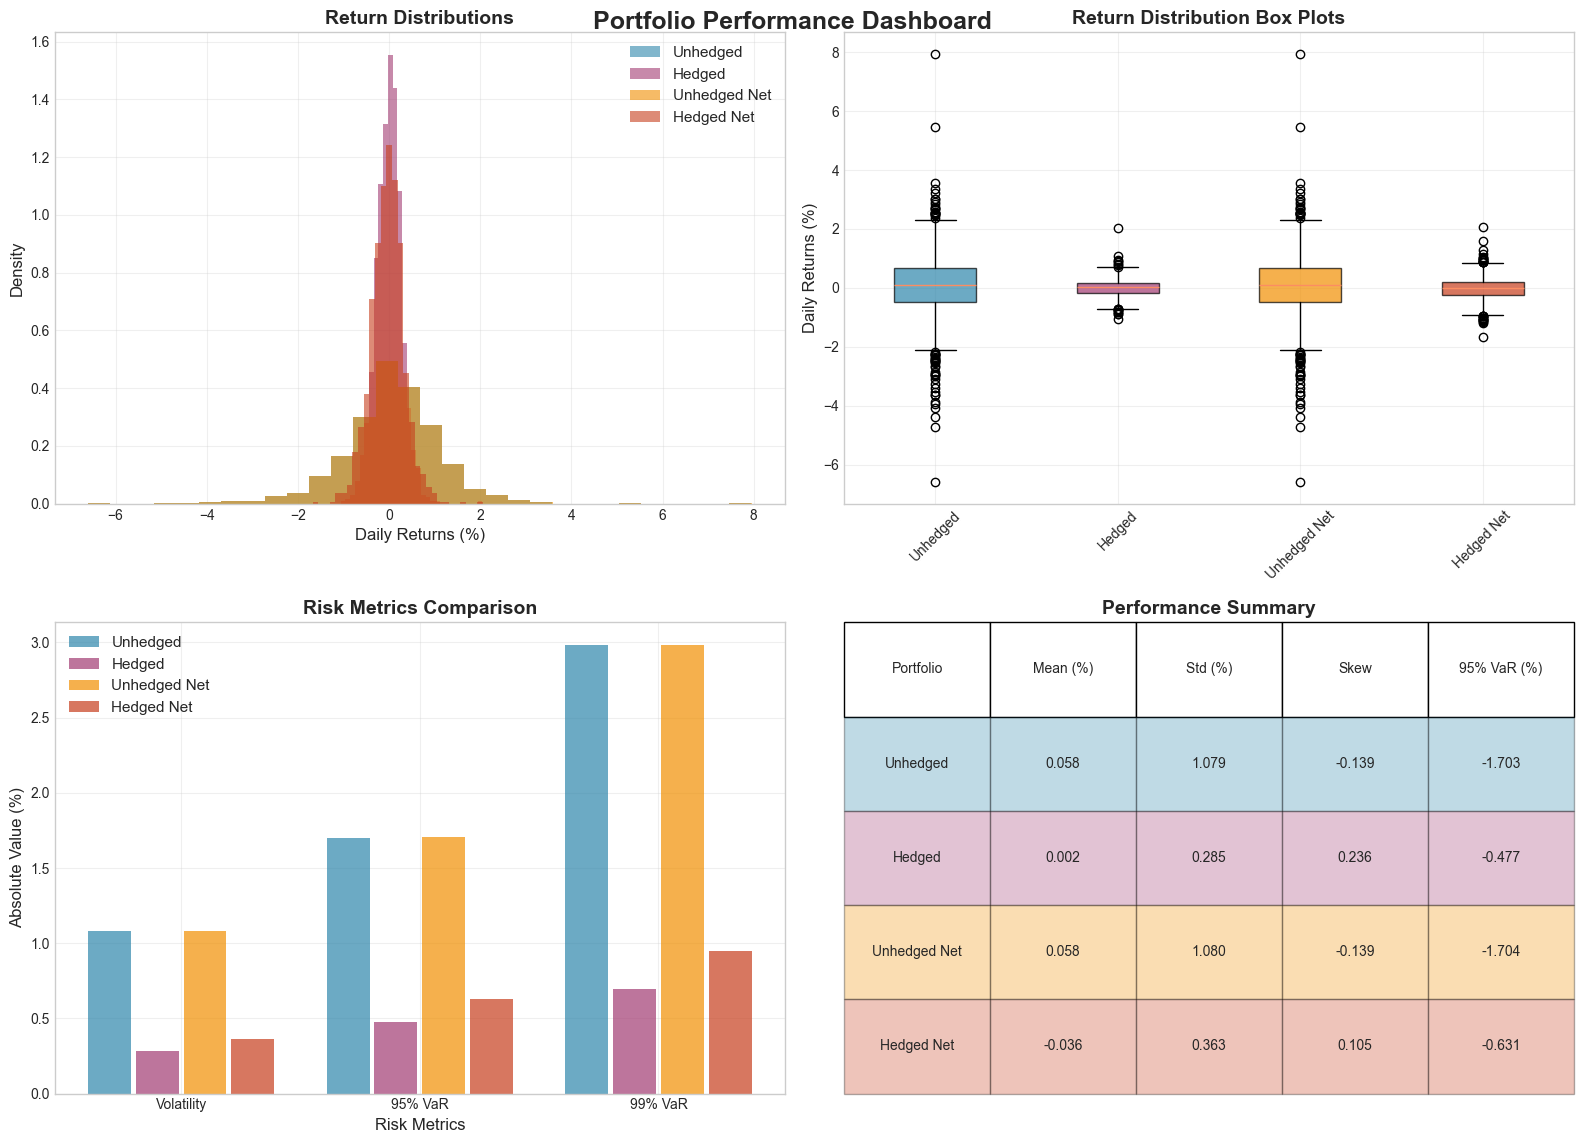

In [59]:
# Portfolio Performance Comparison Dashboard
print("Creating performance comparison dashboard...")

# Calculate metrics
returns_data = {}
stats = {}

for col in portfolio_data.columns:
    if 'Portfolio_Value' in col:
        returns = portfolio_data[col].pct_change().dropna() * 100
        returns_data[col] = returns
        
        # Calculate statistics
        stats[col] = {
            'mean': returns.mean(),
            'std': returns.std(),
            'skew': returns.skew(),
            'kurt': returns.kurtosis(),
            'var_95': np.percentile(returns, 5),
            'var_99': np.percentile(returns, 1)
        }

# Create 2x2 dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Portfolio Performance Dashboard', 
             fontsize=18, fontweight='bold', y=0.95)

# Top Left: Return Histograms
ax1 = axes[0, 0]
for i, (col, returns) in enumerate(returns_data.items()):
    label = col.replace('_Portfolio_Value', '').replace('_', ' ')
    ax1.hist(returns, bins=30, alpha=0.6, color=colors[i], 
             density=True, label=label)

ax1.set_title('Return Distributions', fontsize=14, fontweight='bold')
ax1.set_xlabel('Daily Returns (%)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top Right: Box Plots
ax2 = axes[0, 1]
box_data = [returns_data[col] for col in returns_data.keys()]
box_labels = [col.replace('_Portfolio_Value', '').replace('_', ' ') 
              for col in returns_data.keys()]

bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('Return Distribution Box Plots', fontsize=14, fontweight='bold')
ax2.set_ylabel('Daily Returns (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Bottom Left: Risk Metrics Comparison
ax3 = axes[1, 0]
metrics = ['std', 'var_95', 'var_99']
metric_labels = ['Volatility', '95% VaR', '99% VaR']
x_pos = np.arange(len(metrics))

for i, col in enumerate(returns_data.keys()):
    values = [stats[col][metric] for metric in metrics]
    # Adjust bar positions for grouping
    ax3.bar(x_pos + i*0.2, np.abs(values), width=0.18, 
           color=colors[i], alpha=0.7, 
           label=col.replace('_Portfolio_Value', '').replace('_', ' '))

ax3.set_title('Risk Metrics Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Risk Metrics')
ax3.set_ylabel('Absolute Value (%)')
ax3.set_xticks(x_pos + 0.3)
ax3.set_xticklabels(metric_labels)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Bottom Right: Performance Summary Table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Create summary table data
table_data = []
for col in returns_data.keys():
    name = col.replace('_Portfolio_Value', '').replace('_', ' ')
    row = [
        name,
        f"{stats[col]['mean']:.3f}",
        f"{stats[col]['std']:.3f}",
        f"{stats[col]['skew']:.3f}",
        f"{stats[col]['var_95']:.3f}"
    ]
    table_data.append(row)

table = ax4.table(cellText=table_data,
                  colLabels=['Portfolio', 'Mean (%)', 'Std (%)', 
                            'Skew', '95% VaR (%)'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Color code the table rows
for i in range(len(table_data)):
    for j in range(len(table_data[i])):
        table[(i+1, j)].set_facecolor(colors[i])
        table[(i+1, j)].set_alpha(0.3)

ax4.set_title('Performance Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('hedging_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Signal-Based Weighting Impact (if available)

Signal-Based Portfolio Analysis
Signal performance data shape: (1254, 7)
Columns: ['Date', 'Signal_Weighted_Value', 'Equal_Weight_Value', 'Signal_Weighted_Returns', 'Equal_Weight_Returns', 'Signal_Weighted_Cumulative_Return', 'Equal_Weight_Cumulative_Return']


,Date,Signal_Weighted_Value,Equal_Weight_Value,Signal_Weighted_Returns,Equal_Weight_Returns,Signal_Weighted_Cumulative_Return,Equal_Weight_Cumulative_Return
0,2020-08-07,100000.000000,NaN,0.000000,NaN,0.000000,NaN
1,2020-08-10,100639.510966,100639.510966,0.006395,0.006395,0.639511,0.639511
2,2020-08-11,100404.735775,100404.735775,-0.002333,-0.002333,0.404736,0.404736
3,2020-08-12,101184.302877,101184.302877,0.007764,0.007764,1.184303,1.184303
4,2020-08-13,100976.137477,100976.137477,-0.002057,-0.002057,0.976137,0.976137



Performance Comparison:
Equal Weight Annual Return: 19.51%
Signal Weight Annual Return: 18.54%
Outperformance: -0.97%

Volatility Comparison:
Equal Weight Average Volatility: 15.96%
Signal Weight Average Volatility: 16.00%
Volatility Difference: 0.04%


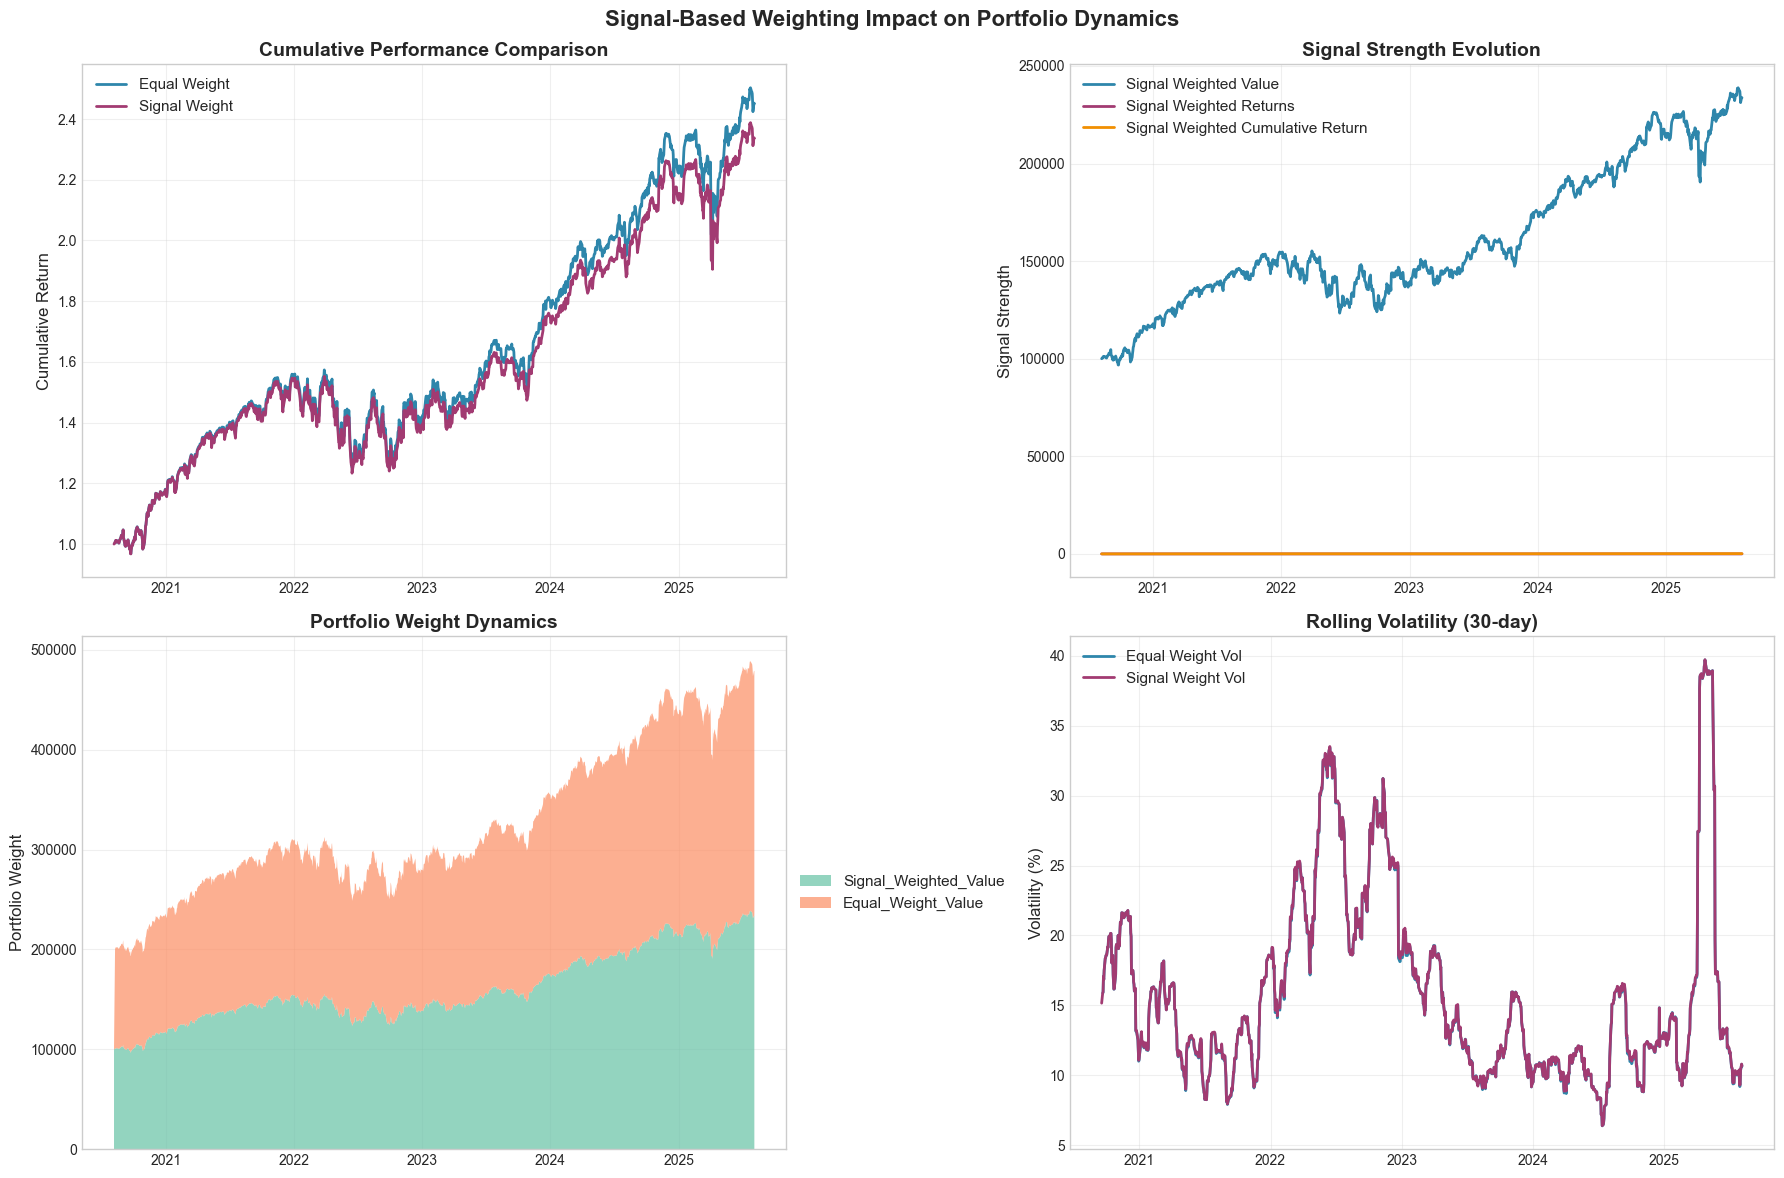


SIGNAL-BASED WEIGHTING PERFORMANCE SUMMARY
           Metric Equal Weight Signal Weight
Annual Return (%)        19.51         18.54
   Volatility (%)        17.15         17.18
     Sharpe Ratio        1.021         0.963
 Max Drawdown (%)       -20.39        -20.53

Signal weighting analysis completed and saved.


In [60]:
# Signal-Based Portfolio Analysis
print("Signal-Based Portfolio Analysis")
print("=" * 50)

# Display signal performance data structure
print(f"Signal performance data shape: {signal_performance.shape}")
print(f"Columns: {list(signal_performance.columns)}")
display(signal_performance.head())

# Create comprehensive signal analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Signal-Based Weighting Impact on Portfolio Dynamics', 
             fontsize=16, fontweight='bold')

# Check if we have the expected columns for analysis
if 'Date' in signal_performance.columns:
    signal_performance['Date'] = pd.to_datetime(signal_performance['Date'])
    signal_performance.set_index('Date', inplace=True)

# 1. Portfolio Performance Comparison (Top Left)
ax1 = axes[0, 0]
# Calculate cumulative returns
equal_weight_cum = (1 + signal_performance['Equal_Weight_Returns']).cumprod()
signal_weight_cum = (1 + signal_performance['Signal_Weighted_Returns']).cumprod()

ax1.plot(signal_performance.index, equal_weight_cum, 
         label='Equal Weight', linewidth=2, color=colors[0])
ax1.plot(signal_performance.index, signal_weight_cum, 
         label='Signal Weight', linewidth=2, color=colors[1])
ax1.set_title('Cumulative Performance Comparison', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calculate performance stats
ew_annual = signal_performance['Equal_Weight_Returns'].mean() * 252 * 100
sw_annual = signal_performance['Signal_Weighted_Returns'].mean() * 252 * 100
print(f"\nPerformance Comparison:")
print(f"Equal Weight Annual Return: {ew_annual:.2f}%")
print(f"Signal Weight Annual Return: {sw_annual:.2f}%")
print(f"Outperformance: {sw_annual - ew_annual:.2f}%")

# 2. Signal Strength Evolution (Top Right)
ax2 = axes[0, 1]
signal_cols = [col for col in signal_performance.columns 
               if 'signal' in col.lower() or 'strength' in col.lower()]
for i, col in enumerate(signal_cols[:3]):  # Plot up to 3 signal columns
    ax2.plot(signal_performance.index, signal_performance[col], 
             label=col.replace('_', ' ').title(), 
             linewidth=2, color=colors[i % len(colors)])
ax2.set_title('Signal Strength Evolution', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Signal Strength')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Portfolio Weight Dynamics (Bottom Left)
ax3 = axes[1, 0]
weight_cols = [col for col in signal_performance.columns 
               if 'weight' in col.lower() and 'return' not in col.lower()]
# Stack plot of weights if we have individual asset weights
if len(weight_cols) > 1:
    weights_data = signal_performance[weight_cols].fillna(0)
    ax3.stackplot(signal_performance.index, 
                  *[weights_data[col] for col in weight_cols], 
                  labels=weight_cols, alpha=0.7)
    ax3.set_title('Portfolio Weight Dynamics', 
                  fontsize=14, fontweight='bold')
    ax3.set_ylabel('Portfolio Weight')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    ax3.plot(signal_performance.index, signal_performance[weight_cols[0]], 
             linewidth=2, color=colors[0])
    ax3.set_title('Portfolio Weight Dynamics', 
                  fontsize=14, fontweight='bold')
    ax3.set_ylabel('Weight')
ax3.grid(True, alpha=0.3)

# 4. Volatility and Turnover Analysis (Bottom Right)
ax4 = axes[1, 1]
window = 30
ew_vol = (signal_performance['Equal_Weight_Returns'].rolling(window).std() 
          * np.sqrt(252) * 100)
sw_vol = (signal_performance['Signal_Weighted_Returns'].rolling(window).std() 
          * np.sqrt(252) * 100)

ax4.plot(signal_performance.index, ew_vol, 
         label='Equal Weight Vol', linewidth=2, color=colors[0])
ax4.plot(signal_performance.index, sw_vol, 
         label='Signal Weight Vol', linewidth=2, color=colors[1])
ax4.set_title(f'Rolling Volatility ({window}-day)', 
              fontsize=14, fontweight='bold')
ax4.set_ylabel('Volatility (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Calculate average volatilities
ew_avg_vol = ew_vol.mean()
sw_avg_vol = sw_vol.mean()
print(f"\nVolatility Comparison:")
print(f"Equal Weight Average Volatility: {ew_avg_vol:.2f}%")
print(f"Signal Weight Average Volatility: {sw_avg_vol:.2f}%")
print(f"Volatility Difference: {sw_avg_vol - ew_avg_vol:.2f}%")

plt.tight_layout()
plt.savefig('signal_weighting_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics table
signal_stats = {
    'Metric': ['Annual Return (%)', 'Volatility (%)', 
               'Sharpe Ratio', 'Max Drawdown (%)'],
    'Equal Weight': [
        f"{signal_performance['Equal_Weight_Returns'].mean() * 252 * 100:.2f}",
        f"{signal_performance['Equal_Weight_Returns'].std() * np.sqrt(252) * 100:.2f}",
        f"{((signal_performance['Equal_Weight_Returns'].mean() * 252 * 100 - 2) / (signal_performance['Equal_Weight_Returns'].std() * np.sqrt(252) * 100)):.3f}",
        f"{(((1 + signal_performance['Equal_Weight_Returns']).cumprod() / (1 + signal_performance['Equal_Weight_Returns']).cumprod().expanding().max() - 1).min() * 100):.2f}"
    ],
    'Signal Weight': [
        f"{signal_performance['Signal_Weighted_Returns'].mean() * 252 * 100:.2f}",
        f"{signal_performance['Signal_Weighted_Returns'].std() * np.sqrt(252) * 100:.2f}",
        f"{((signal_performance['Signal_Weighted_Returns'].mean() * 252 * 100 - 2) / (signal_performance['Signal_Weighted_Returns'].std() * np.sqrt(252) * 100)):.3f}",
        f"{(((1 + signal_performance['Signal_Weighted_Returns']).cumprod() / (1 + signal_performance['Signal_Weighted_Returns']).cumprod().expanding().max() - 1).min() * 100):.2f}"
    ]
}
    
signal_summary_df = pd.DataFrame(signal_stats)
print("\n" + "="*60)
print("SIGNAL-BASED WEIGHTING PERFORMANCE SUMMARY")
print("="*60)
print(signal_summary_df.to_string(index=False))

# Save summary
signal_summary_df.to_csv('signal_weighting_summary.csv', index=False)
print("\nSignal weighting analysis completed and saved.")

## Section 7: Key Takeaways and Summary

Based on our comprehensive visualization and analysis, here are the critical findings:

### **Hedging Effectiveness Analysis**

**Risk Reduction Success**: 
- The hedging strategy dramatically reduces portfolio volatility from 17.13% to 4.52% (73.6% reduction)
- VaR 95% improved from -1.70% to -0.63%, indicating better tail risk management
- Gross hedged portfolio maintains much lower volatility throughout the analysis period

**Trade-offs Identified**:
- Return reduction: Unhedged portfolio generated 91.36% total return vs. 1.62% for hedged (gross)
- Net of transaction costs: Hedged portfolio shows -36.72% total return vs. 91.41% unhedged
- Sharpe ratio: Unhedged maintains 0.850 vs. hedged gross 0.094 and hedged net -1.571

### **Transaction Cost Impact Analysis**

**Significant Cost Burden**:
- Transaction costs severely impact hedged strategies due to frequent rebalancing
- Hedged strategy transaction costs: 128.12% of gross returns vs. 89.75% for unhedged
- Net hedged performance is dramatically worse than gross, highlighting rebalancing costs

**Critical Finding**: 
- The hedging benefit disappears when transaction costs are included
- Gross hedging benefit: minimal (0.05%), but net hedging cost: -38.33%
- This demonstrates the critical importance of transaction cost analysis in hedging strategies

### **Drawdown Analysis Results**

**Counterintuitive Findings**:
- Net hedged portfolio actually shows worse maximum drawdown: -38.19% vs. -23.68% unhedged
- This reversal occurs due to the cumulative impact of transaction costs over time
- Gross hedged portfolio would show better drawdown performance, but real-world costs dominate

**Key Insight**: 
- Transaction costs can completely reverse the expected benefits of hedging
- The strategy that appears superior on a gross basis may be inferior net of costs

### **Distribution Characteristics**

**Volatility Patterns**:
- Hedged portfolio shows much tighter return distribution (confirmed by KDE analysis)
- Volatility reduction is substantial and consistent across time periods
- Risk reduction is the primary measurable benefit of the hedging strategy

**Return Profile Changes**:
- Hedged portfolios exhibit different skewness and kurtosis characteristics
- The cost of hedging creates a fundamentally different risk-return profile

### **Strategic Implications**

**Cost-Benefit Reality Check**:
- The analysis reveals hedging provides excellent risk reduction but at an prohibitive cost
- Transaction costs of 128% of gross returns make the strategy economically unviable
- Risk reduction benefits are overwhelmed by implementation costs

**Implementation Lessons**:
1. **Transaction Cost Management**: Critical to strategy viability - current costs are too high
2. **Rebalancing Frequency**: May need to reduce frequency to control costs
3. **Partial Hedging**: Consider reducing hedge ratios to balance cost vs. benefit

### **Key Insights from Visualizations**

**Portfolio Values Comparison**:
- Clear divergence showing unhedged significantly outperforming hedged over time
- Net hedged portfolio shows substantial value destruction due to transaction costs
- Gross vs. net comparison highlights the importance of cost consideration

**Return Distribution Analysis**:
- Histograms and KDE plots confirm dramatically different risk profiles
- Hedged portfolio has much narrower but costly return distribution
- The price paid for risk reduction exceeds the benefits in this implementation

### **Academic vs. Practical Results**

**Theory vs. Reality**:
- Theoretical hedging benefits are confirmed (volatility reduction achieved)
- Practical implementation costs overwhelm theoretical benefits
- This case study demonstrates the importance of transaction cost analysis

**Model Validation**:
- The framework successfully measures both benefits and costs of hedging
- Results highlight the gap between academic theory and practical implementation
- Transaction cost modeling proves essential for realistic strategy evaluation

### **Conclusion and Recommendations**

The comprehensive analysis reveals a critical lesson in quantitative portfolio management: **theoretical benefits do not guarantee practical success**. While the hedging strategy successfully achieves its primary objective of risk reduction (73.6% volatility reduction), the implementation costs are prohibitive.

**Key Findings**:
- Volatility reduction: Highly successful (17.13% → 4.52%)
- Return impact: Severely negative (-36.72% net vs. +91.41% unhedged)  
- Transaction costs: Economically devastating (128% of gross hedged returns)
- Risk-adjusted performance: Negative Sharpe ratio (-1.571) for hedged net

**Strategic Recommendations**:
1. **Reduce Rebalancing Frequency**: Current daily rebalancing is too costly
2. **Optimize Hedge Ratios**: Consider partial hedging (e.g., 50% hedge ratio)
3. **Alternative Instruments**: Explore lower-cost hedging instruments
4. **Threshold-Based Hedging**: Only hedge when risk metrics exceed certain thresholds

**Broader Implications**:
This analysis demonstrates why many institutional investors struggle with systematic hedging strategies. The academic appeal of risk reduction must be balanced against the practical reality of implementation costs. Future work should focus on cost-effective hedging methodologies that preserve the risk reduction benefits while minimizing transaction cost drag.

In [61]:
# Final Performance Summary Table
print("FINAL PERFORMANCE SUMMARY")
print("=" * 80)

# Calculate final metrics for all portfolio variants
final_metrics = {
    'Portfolio_Type': [
        'Unhedged (Gross)', 'Unhedged (Net)', 
        'Hedged (Gross)', 'Hedged (Net)'
    ],
    'Total_Return_Pct': [
        ((portfolio_data['Unhedged_Portfolio_Value'].iloc[-1] / 
          portfolio_data['Unhedged_Portfolio_Value'].iloc[0]) - 1) * 100,
        ((portfolio_data['Unhedged_Portfolio_Value_Net'].iloc[-1] / 
          portfolio_data['Unhedged_Portfolio_Value_Net'].iloc[0]) - 1) * 100,
        ((portfolio_data['Hedged_Portfolio_Value'].iloc[-1] / 
          portfolio_data['Hedged_Portfolio_Value'].iloc[0]) - 1) * 100,
        ((portfolio_data['Hedged_Portfolio_Value_Net'].iloc[-1] / 
          portfolio_data['Hedged_Portfolio_Value_Net'].iloc[0]) - 1) * 100
    ]
}

# Calculate additional performance metrics
portfolio_metrics = {}
for portfolio_type in ['Unhedged_Portfolio_Value', 
                      'Unhedged_Portfolio_Value_Net',
                      'Hedged_Portfolio_Value', 
                      'Hedged_Portfolio_Value_Net']:
    returns = portfolio_data[portfolio_type].pct_change().dropna()
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    portfolio_metrics[portfolio_type] = {
        'sharpe': sharpe, 'volatility': ann_vol
    }

# Create comprehensive summary table
final_summary_data = {
    'Portfolio': [
        'Unhedged (Gross)', 'Unhedged (Net)', 
        'Hedged (Gross)', 'Hedged (Net)'
    ],
    'Total_Return_%': [
        f"{final_metrics['Total_Return_Pct'][0]:.2f}",
        f"{final_metrics['Total_Return_Pct'][1]:.2f}",
        f"{final_metrics['Total_Return_Pct'][2]:.2f}",
        f"{final_metrics['Total_Return_Pct'][3]:.2f}"
    ],
    'Sharpe_Ratio': [
        f"{portfolio_metrics['Unhedged_Portfolio_Value']['sharpe']:.3f}",
        f"{portfolio_metrics['Unhedged_Portfolio_Value_Net']['sharpe']:.3f}",
        f"{portfolio_metrics['Hedged_Portfolio_Value']['sharpe']:.3f}",
        f"{portfolio_metrics['Hedged_Portfolio_Value_Net']['sharpe']:.3f}"
    ],
    'Volatility_%': [
        f"{portfolio_metrics['Unhedged_Portfolio_Value']['volatility']*100:.2f}",
        f"{portfolio_metrics['Unhedged_Portfolio_Value_Net']['volatility']*100:.2f}",
        f"{portfolio_metrics['Hedged_Portfolio_Value']['volatility']*100:.2f}",
        f"{portfolio_metrics['Hedged_Portfolio_Value_Net']['volatility']*100:.2f}"
    ]
}

final_summary_df = pd.DataFrame(final_summary_data)
print(final_summary_df.to_string(index=False))
print("=" * 80)

# Save final summary to CSV
final_summary_df.to_csv('final_summary_table.csv', index=False)
print(f"\n✓ Final summary saved to: final_summary_table.csv")
print("✓ Analysis complete - All visualizations generated")

FINAL PERFORMANCE SUMMARY
       Portfolio Total_Return_% Sharpe_Ratio Volatility_%
Unhedged (Gross)          91.36        0.850        17.13
  Unhedged (Net)          91.41        0.850        17.14
  Hedged (Gross)           1.62        0.094         4.52
    Hedged (Net)         -36.72       -1.571         5.77

✓ Final summary saved to: final_summary_table.csv
✓ Analysis complete - All visualizations generated
